In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import itertools as it
import glob
import numpy as np

from typing import Optional, List, Tuple
from copy import deepcopy

from ssvm_evaluation.plotting_utils import table__top_k_acc_per_dataset_with_significance

# Plots for the comparison of the different methods 
from ssvm_evaluation.plotting_utils import plot__03__a, plot__03__b

from ssvm_evaluation.utils import dict2fn, load_topk__comparison, load_topk__publication, load_topk__cand_set_info

In [2]:
def _check_onlyms(reference: pd.DataFrame, others: List[pd.DataFrame], n_samples: int = 1500, random_state: Optional[int] = None):    
    # Ensure input being a list
    if isinstance(others, pd.DataFrame): 
        others = [others]
    
    # We only need to ensure, that the Only MS performance is equal
    _ref = reference[reference["scoring_method"] == "Only MS"]
    _others = [o[o["scoring_method"] == "Only MS"] for o in others if len(o) > 0]
    
    # Go over a random sub-set of rows in the reference data
    n_tests = np.zeros(len(others))
    for _, (x, y, z) in _ref[["dataset", "eval_indx", "k"]].sample(n=n_samples, random_state=random_state).drop_duplicates().iterrows():
        # Top-k accuracy of the reference
        _acc_ref = _ref[(_ref["dataset"] == x) & (_ref["eval_indx"] == y) & (_ref["k"] == z)]["top_k_acc"]

        # Top-k accuracy of the others
        _acc_others = [_o[(_o["dataset"] == x) & (_o["eval_indx"] == y) & (_o["k"] == z)]["top_k_acc"] for _o in _others]
        
        # The top-k accuracy of the reference must be equal to the one of the others
        for i in range(len(_others)):
            if len(_acc_others[i]) == 0:
                continue
            
            try: 
                # assert _acc_ref.item() ==  _acc_others[i].item()
                assert np.allclose(_acc_ref.item(), _acc_others[i].item())
            except AssertionError:
                print(i, x, y, z, _acc_ref.item(), _acc_others[i].item())
                
            n_tests[i] += 1
    
    print("Performed tests:", n_tests)

# Experiment 4: Study of the importance of 3D encoding fingerprints

TODO

## Load raw results for all three MS$^2$ scorers

In [3]:
agg_setting = {
    "marg_agg_fun": "average",
    "cand_agg_id": "inchikey1"
}

### MetFrag

MetFrag performs an in-silico fragmentation for each candidate structure and compares the predicted and observed (from the MS2 spectrum) fragments. 

In [4]:
# SSVM (2D)
setting = {"ds": "*", "mol_feat": "FCFP__binary__all__2D", "mol_id": "cid", "ms2scorer": "metfrag__norm", "ssvm_flavor": "default", "lloss_mode": "mol_feat_fps"}
res__ssvm__metfrag__2D = load_topk__publication(
    setting, agg_setting, basedir=os.path.join("massbank"), top_k_method="csi", load_max_model_number=True
)

# SSVM (3D)
setting = {"ds": "*", "mol_feat": "FCFP__binary__all__3D", "mol_id": "cid", "ms2scorer": "metfrag__norm", "ssvm_flavor": "default", "lloss_mode": "mol_feat_fps"}
res__ssvm__metfrag__3D = load_topk__publication(
    setting, agg_setting, basedir=os.path.join("massbank"), top_k_method="csi", load_max_model_number=True
)

# Perform some sanity checks
assert res__ssvm__metfrag__2D["scoring_method"].nunique() == 2
assert res__ssvm__metfrag__3D["scoring_method"].nunique() == 2

_check_onlyms(res__ssvm__metfrag__2D, [res__ssvm__metfrag__3D])

Performed tests: [1500.]


#### Overview result table (LC-MS$^2$Struct)

##### Without chrirality encoding (2D)

In [5]:
tab = table__top_k_acc_per_dataset_with_significance(res__ssvm__metfrag__2D, test="ttest", ks=[1, 5, 10, 20])
tab.pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1                 5                 10            \
scoring_method    Only MS   MS + RT Only MS   MS + RT Only MS   MS + RT   
dataset n_samples                                                         
AC_003  15           12.3  | 18.3 *    38.3  | 40.7 *  | 47.1      46.5   
AU_000  15            9.5  | 16.8 *    32.9  | 39.9 *    43.5  | 49.1 *   
AU_002  14            4.7   | 7.0 *    20.4  | 26.5 *    31.9  | 38.3 *   
AU_003  15          | 5.2       3.9    19.1  | 25.1 *    27.8  | 36.9 *   
BML_000 15            3.1   | 6.1 *    16.8    | 18.4    23.1  | 25.6 *   
BML_001 15            3.5   | 6.1 *    16.7  | 22.9 *    22.1  | 31.2 *   
BS_000  15           12.0  | 13.8 *    22.9  | 28.3 *    27.7  | 37.3 *   
CE_001  1           | 2.1       0.0     8.6    | 10.3    17.7    | 23.1   
EA_000  15           12.1  | 25.6 *    36.3  | 50.8 *    47.5  | 63.3 *   
EA_001  15           14.5  | 25.3 *    39.3  | 52.3 *    50.2  | 59.7 *   
EA_002  6             4.4  | 10.4 *    23.6  | 34.6 *    38.9  | 48.5 *   
EA_003  6             8.0  | 14.8 *    31.4  | 41.7 *    46.7  | 54.7 *   
EQ_001  15            5.5  | 11.3 *    36.2  | 45.0 *    52.4  | 54.2 *   
EQ_003  15            7.1   | 9.7 *    29.7  | 39.5 *    44.1  | 56.4 *   
EQ_004  15            5.3   | 9.4 *    29.3  | 37.1 *    43.0  | 49.7 *   
EQ_006  15            5.5   | 9.1 *    26.9  | 36.3 *    35.6  | 46.7 *   
ET_002  1             7.8    | 10.0  | 23.9      20.0  | 30.4      26.0   
KW_000  1             1.9     | 5.5     6.7    | 21.8    13.6    | 25.5   
LQB_000 6             9.8    | 11.7    44.7    | 46.7    62.8    | 66.5   
LU_000  7             7.1  | 11.6 *    31.2  | 37.7 *    43.6  | 51.1 *   
LU_001  11            7.5   | 9.5 *    29.7  | 36.6 *    40.5  | 48.1 *   
NA_003  15            2.8  | 11.7 *    20.9  | 26.0 *    27.3  | 33.9 *   
PR_000  14           10.2  | 15.4 *    29.1  | 36.6 *    41.2  | 47.9 *   
PR_002  18            8.4  | 10.9 *    22.6  | 28.3 *    32.6  | 39.5 *   
RP_000  1             5.5     | 7.4    16.4    | 26.8    25.2    | 39.3   
RP_001  15            6.0   | 9.2 *    21.7  | 31.6 *    32.2  | 39.6 *   
SM_000  15            6.5  | 13.3 *    28.0  | 36.5 *    40.7  | 48.9 *   
SM_001  7             3.8   | 7.0 *    21.8  | 30.7 *    35.4  | 44.8 *   
UF_002  15            2.9   | 6.4 *    19.0  | 28.8 *    26.2  | 38.3 *   
UF_003  15            1.6   | 3.9 *    15.1  | 25.0 *    24.1  | 35.5 *   
UT_000  6             2.6     | 3.0    18.1    | 22.0    31.8  | 36.1 *   

k                      20            
scoring_method    Only MS   MS + RT  
dataset n_samples                    
AC_003  15           52.0  | 53.2 *  
AU_000  15           55.1  | 63.0 *  
AU_002  14           42.5  | 51.2 *  
AU_003  15           35.3  | 47.5 *  
BML_000 15           31.0  | 36.0 *  
BML_001 15           29.7  | 38.0 *  
BS_000  15           33.2  | 48.7 *  
CE_001  1            25.9    | 38.5  
EA_000  15           57.4  | 72.9 *  
EA_001  15           62.2  | 72.4 *  
EA_002  6            49.8  | 57.5 *  
EA_003  6            58.5  | 67.1 *  
EQ_001  15           59.4  | 66.4 *  
EQ_003  15           57.4  | 66.1 *  
EQ_004  15           55.2  | 59.9 *  
EQ_006  15           46.8  | 58.9 *  
ET_002  1          | 32.6      32.0  
KW_000  1            20.9    | 38.2  
LQB_000 6            82.2    | 82.4  
LU_000  7            54.0  | 60.9 *  
LU_001  11           51.3  | 57.3 *  
NA_003  15           37.3  | 41.7 *  
PR_000  14           57.1  | 63.8 *  
PR_002  18           43.5  | 50.2 *  
RP_000  1            32.1    | 44.9  
RP_001  15           42.0  | 49.1 *  
SM_000  15           51.2  | 60.7 *  
SM_001  7            50.1  | 60.2 *  
UF_002  15           34.0  | 50.0 *  
UF_003  15           34.2  | 46.5 *  
UT_000  6            49.5  | 53.9 *

##### With chirality encoding (3D)

In [6]:
tab = table__top_k_acc_per_dataset_with_significance(res__ssvm__metfrag__3D, test="ttest", ks=[1, 5, 10, 20])
tab.pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1                 5                 10            \
scoring_method    Only MS   MS + RT Only MS   MS + RT Only MS   MS + RT   
dataset n_samples                                                         
AC_003  15           12.3  | 20.1 *    38.3  | 42.1 *    47.1  | 48.7 *   
AU_000  15            9.5  | 20.0 *    32.9  | 41.6 *    43.5  | 50.0 *   
AU_002  14            4.7   | 9.0 *    20.4  | 27.8 *    31.9  | 40.0 *   
AU_003  15            5.2   | 8.0 *    19.1  | 28.9 *    27.8  | 38.3 *   
BML_000 15            3.1   | 9.5 *    16.8  | 22.5 *    23.1  | 30.3 *   
BML_001 15            3.5   | 7.2 *    16.7  | 25.1 *    22.1  | 34.3 *   
BS_000  15           12.0  | 17.0 *    22.9  | 34.8 *    27.7  | 44.5 *   
CE_001  1             2.1     | 2.6     8.6    | 12.8    17.7    | 28.2   
EA_000  15           12.1  | 28.1 *    36.3  | 52.3 *    47.5  | 65.3 *   
EA_001  15           14.5  | 26.9 *    39.3  | 53.4 *    50.2  | 61.6 *   
EA_002  6             4.4  | 10.8 *    23.6  | 35.9 *    38.9  | 49.3 *   
EA_003  6             8.0  | 18.4 *    31.4  | 42.2 *    46.7  | 55.4 *   
EQ_001  15            5.5  | 13.1 *    36.2  | 46.1 *    52.4  | 55.2 *   
EQ_003  15            7.1  | 12.3 *    29.7  | 42.0 *    44.1  | 57.1 *   
EQ_004  15            5.3  | 11.8 *    29.3  | 38.0 *    43.0  | 50.4 *   
EQ_006  15            5.5  | 11.1 *    26.9  | 38.2 *    35.6  | 49.9 *   
ET_002  1             7.8    | 10.0  | 23.9      20.0  | 30.4      26.0   
KW_000  1             1.9     | 3.6     6.7    | 21.8    13.6    | 29.1   
LQB_000 6             9.8  | 27.9 *    44.7  | 60.5 *    62.8  | 75.0 *   
LU_000  7             7.1  | 12.2 *    31.2  | 37.9 *    43.6  | 52.3 *   
LU_001  11            7.5  | 10.8 *    29.7  | 36.8 *    40.5  | 48.3 *   
NA_003  15            2.8  | 14.7 *    20.9  | 28.8 *    27.3  | 37.2 *   
PR_000  14           10.2  | 22.1 *    29.1  | 48.8 *    41.2  | 59.2 *   
PR_002  18            8.4  | 15.3 *    22.6  | 36.1 *    32.6  | 46.9 *   
RP_000  1             5.5    | 13.0    16.4    | 31.4    25.2    | 43.3   
RP_001  15            6.0  | 13.3 *    21.7  | 35.3 *    32.2  | 44.0 *   
SM_000  15            6.5  | 14.0 *    28.0  | 37.9 *    40.7  | 51.5 *   
SM_001  7             3.8   | 8.0 *    21.8  | 31.5 *    35.4  | 46.5 *   
UF_002  15            2.9   | 7.6 *    19.0  | 30.9 *    26.2  | 40.0 *   
UF_003  15            1.6   | 5.3 *    15.1  | 26.4 *    24.1  | 37.3 *   
UT_000  6             2.6   | 6.4 *    18.1  | 30.3 *    31.8  | 45.5 *   

k                      20            
scoring_method    Only MS   MS + RT  
dataset n_samples                    
AC_003  15           52.0  | 54.4 *  
AU_000  15           55.1  | 64.8 *  
AU_002  14           42.5  | 52.4 *  
AU_003  15           35.3  | 50.7 *  
BML_000 15           31.0  | 39.5 *  
BML_001 15           29.7  | 41.7 *  
BS_000  15           33.2  | 56.2 *  
CE_001  1            25.9    | 43.6  
EA_000  15           57.4  | 74.4 *  
EA_001  15           62.2  | 74.3 *  
EA_002  6            49.8  | 57.8 *  
EA_003  6            58.5  | 67.8 *  
EQ_001  15           59.4  | 67.3 *  
EQ_003  15           57.4  | 67.1 *  
EQ_004  15           55.2  | 61.1 *  
EQ_006  15           46.8  | 61.7 *  
ET_002  1            32.6    | 34.0  
KW_000  1            20.9    | 40.0  
LQB_000 6            82.2  | 89.6 *  
LU_000  7            54.0    | 59.5  
LU_001  11           51.3  | 58.2 *  
NA_003  15           37.3  | 45.5 *  
PR_000  14           57.1  | 71.1 *  
PR_002  18           43.5  | 56.3 *  
RP_000  1            32.1    | 47.8  
RP_001  15           42.0  | 54.7 *  
SM_000  15           51.2  | 60.3 *  
SM_001  7            50.1  | 60.5 *  
UF_002  15           34.0  | 49.9 *  
UF_003  15           34.2  | 47.4 *  
UT_000  6            49.5  | 64.5 *

## SIRIUS

In [7]:
# SSVM (2D)
setting = {"ds": "*", "mol_feat": "FCFP__binary__all__2D", "mol_id": "cid", "ms2scorer": "sirius__norm", "ssvm_flavor": "default", "lloss_mode": "mol_feat_fps"}
res__ssvm__sirius__2D = load_topk__publication(
    setting, agg_setting, basedir=os.path.join("massbank"), top_k_method="csi", load_max_model_number=True
)

# SSVM (3D)
setting = {"ds": "*", "mol_feat": "FCFP__binary__all__3D", "mol_id": "cid", "ms2scorer": "sirius__norm", "ssvm_flavor": "default", "lloss_mode": "mol_feat_fps"}
res__ssvm__sirius__3D = load_topk__publication(
    setting, agg_setting, basedir=os.path.join("massbank"), top_k_method="csi", load_max_model_number=True
)

# Perform some sanity checks
assert res__ssvm__sirius__2D["scoring_method"].nunique() == 2
assert res__ssvm__sirius__3D["scoring_method"].nunique() == 2

_check_onlyms(res__ssvm__sirius__2D, [res__ssvm__sirius__3D])

Performed tests: [1500.]


#### Overview result table (LC-MS$^2$Struct)

##### Without chrirality encoding (2D)

In [8]:
tab = table__top_k_acc_per_dataset_with_significance(res__ssvm__sirius__2D, test="ttest", ks=[1, 5, 10, 20])
tab.pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1                 5                 10            \
scoring_method    Only MS   MS + RT Only MS   MS + RT Only MS   MS + RT   
dataset n_samples                                                         
AC_003  15           27.2  | 29.5 *  | 58.5      58.4  | 63.2      62.7   
AU_000  15           30.4    | 30.9    56.1    | 56.5    64.3    | 64.7   
AU_002  14         | 41.7      41.5    64.5    | 65.1  | 72.1    | 72.1   
AU_003  15         | 38.0      37.1  | 66.0      65.3  | 72.0      71.6   
BML_000 15         | 21.9    | 21.9    57.1    | 57.9  | 65.6      65.3   
BML_001 15           28.8    | 28.9  | 66.7    | 66.7    73.6  | 74.3 *   
BS_000  15         | 30.0      29.2  | 58.7      58.4    68.0  | 70.0 *   
CE_001  1            52.6    | 53.8  | 74.4    | 74.4  | 82.1    | 82.1   
EA_000  15           41.9  | 43.2 *    62.8  | 63.3 *    66.5  | 68.8 *   
EA_001  15           40.3    | 41.1    68.7  | 70.1 *    75.6  | 77.2 *   
EA_002  6            38.9    | 40.0    64.8    | 66.1    72.7    | 73.4   
EA_003  6            55.0    | 55.4  | 80.8      80.4    85.0    | 85.3   
EQ_001  15           26.6  | 28.7 *    58.1  | 60.7 *  | 67.9      67.5   
EQ_003  15         | 38.9      37.2    63.3    | 64.1    73.1    | 73.3   
EQ_004  15           42.3    | 43.2    68.1    | 68.8  | 75.6      75.2   
EQ_006  15         | 49.1      48.6    72.1  | 73.7 *  | 78.7    | 78.7   
ET_002  1          | 48.0    | 48.0  | 78.0      74.0  | 84.0    | 84.0   
KW_000  1            23.6    | 25.5  | 45.5      41.8  | 54.5    | 54.5   
LQB_000 6            14.5  | 15.3 *    33.2    | 34.0    51.3    | 51.5   
LU_000  7          | 28.4      27.4    54.8  | 57.6 *    64.5  | 65.7 *   
LU_001  11         | 34.0      33.5  | 59.8    | 59.8  | 67.9      67.7   
NA_003  15           37.1  | 38.5 *  | 68.4      67.1  | 77.6      77.5   
PR_000  14           25.4    | 26.1    57.4    | 58.4    71.2  | 72.2 *   
PR_002  18         | 33.4      33.2  | 65.3    | 65.3  | 76.4      76.1   
RP_000  1          | 34.8    | 34.8  | 46.4    | 46.4  | 60.9    | 60.9   
RP_001  15           55.0  | 55.9 *    80.3  | 81.5 *  | 90.5      88.0   
SM_000  15           37.2  | 38.7 *    57.5    | 57.7    69.2  | 70.0 *   
SM_001  7            44.1    | 44.3    74.4    | 75.2    80.4    | 81.0   
UF_002  15           39.9  | 41.9 *    63.5  | 65.3 *    71.1  | 73.6 *   
UF_003  15         | 40.7      40.5    68.4  | 70.0 *    75.7    | 75.9   
UT_000  6            18.9    | 19.0    35.9    | 36.7    41.8  | 42.3 *   

k                      20            
scoring_method    Only MS   MS + RT  
dataset n_samples                    
AC_003  15         | 64.8      64.5  
AU_000  15         | 68.7      68.5  
AU_002  14         | 77.5    | 77.5  
AU_003  15           76.9    | 77.5  
BML_000 15           74.1  | 75.1 *  
BML_001 15           79.5    | 79.7  
BS_000  15           79.7    | 80.3  
CE_001  1          | 94.9    | 94.9  
EA_000  15           73.5  | 75.5 *  
EA_001  15           79.2    | 79.3  
EA_002  6          | 79.7    | 79.7  
EA_003  6          | 89.9    | 89.9  
EQ_001  15           68.9    | 69.2  
EQ_003  15           78.4  | 80.3 *  
EQ_004  15           78.7  | 79.3 *  
EQ_006  15           83.7    | 84.4  
ET_002  1            88.0    | 90.0  
KW_000  1          | 60.6      58.2  
LQB_000 6            72.0    | 72.6  
LU_000  7            73.8    | 74.6  
LU_001  11           74.0  | 75.3 *  
NA_003  15           79.6  | 80.3 *  
PR_000  14           79.1  | 79.5 *  
PR_002  18           83.0    | 83.3  
RP_000  1          | 68.1    | 68.1  
RP_001  15           93.3    | 93.5  
SM_000  15           78.3    | 79.2  
SM_001  7            85.2    | 85.4  
UF_002  15         | 78.8      78.1  
UF_003  15           81.7    | 81.9  
UT_000  6            55.6  | 56.4 *

##### With chirality encoding (3D)

In [9]:
tab = table__top_k_acc_per_dataset_with_significance(res__ssvm__sirius__3D, test="ttest", ks=[1, 5, 10, 20])
tab.pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1                 5                 10            \
scoring_method    Only MS   MS + RT Only MS   MS + RT Only MS   MS + RT   
dataset n_samples                                                         
AC_003  15           27.2  | 31.5 *    58.5  | 60.1 *    63.2  | 63.9 *   
AU_000  15           30.4  | 31.5 *    56.1  | 57.6 *    64.3  | 65.5 *   
AU_002  14           41.7    | 41.9    64.5    | 65.4    72.1    | 72.4   
AU_003  15           38.0    | 38.7  | 66.0      65.3    72.0    | 72.4   
BML_000 15           21.9  | 25.6 *    57.1  | 59.5 *    65.6  | 67.6 *   
BML_001 15           28.8  | 31.3 *    66.7  | 68.9 *    73.6  | 75.3 *   
BS_000  15           30.0  | 35.1 *    58.7  | 62.8 *    68.0  | 72.1 *   
CE_001  1            52.6    | 53.8  | 74.4    | 74.4    82.1    | 84.6   
EA_000  15           41.9  | 43.5 *    62.8  | 65.0 *    66.5  | 69.9 *   
EA_001  15           40.3  | 42.4 *    68.7  | 71.3 *    75.6  | 78.0 *   
EA_002  6            38.9    | 41.7    64.8    | 66.8    72.7  | 75.7 *   
EA_003  6          | 55.0      54.5  | 80.8      80.6    85.0    | 86.0   
EQ_001  15           26.6  | 28.0 *    58.1  | 62.5 *  | 67.9      67.6   
EQ_003  15         | 38.9      37.9    63.3  | 66.0 *    73.1    | 73.5   
EQ_004  15           42.3  | 43.6 *    68.1  | 70.7 *    75.6    | 76.3   
EQ_006  15         | 49.1      49.0    72.1  | 74.4 *    78.7    | 79.3   
ET_002  1          | 48.0    | 48.0  | 78.0      76.0  | 84.0    | 84.0   
KW_000  1            23.6    | 27.3    45.5    | 47.3    54.5    | 56.4   
LQB_000 6            14.5  | 23.9 *    33.2  | 46.3 *    51.3  | 61.0 *   
LU_000  7            28.4    | 28.9    54.8  | 57.2 *    64.5    | 65.4   
LU_001  11         | 34.0      33.4    59.8    | 60.7    67.9    | 68.6   
NA_003  15           37.1  | 39.3 *    68.4    | 69.1    77.6    | 77.9   
PR_000  14           25.4  | 31.9 *    57.4  | 65.0 *    71.2  | 76.3 *   
PR_002  18           33.4  | 37.1 *    65.3  | 70.9 *    76.4  | 79.3 *   
RP_000  1            34.8    | 40.6    46.4    | 55.1    60.9    | 63.8   
RP_001  15           55.0  | 58.5 *    80.3  | 84.8 *    90.5    | 90.9   
SM_000  15           37.2  | 40.3 *    57.5  | 58.8 *    69.2  | 70.9 *   
SM_001  7            44.1    | 44.7  | 74.4      74.2    80.4    | 80.7   
UF_002  15           39.9  | 43.2 *    63.5  | 67.2 *    71.1  | 74.7 *   
UF_003  15           40.7    | 41.5    68.4  | 70.8 *    75.7    | 76.1   
UT_000  6            18.9    | 19.3    35.9  | 39.1 *    41.8  | 49.0 *   

k                      20            
scoring_method    Only MS   MS + RT  
dataset n_samples                    
AC_003  15         | 64.8      64.5  
AU_000  15         | 68.7      68.3  
AU_002  14           77.5  | 78.4 *  
AU_003  15           76.9  | 78.3 *  
BML_000 15           74.1  | 76.5 *  
BML_001 15           79.5    | 79.7  
BS_000  15           79.7  | 82.1 *  
CE_001  1          | 94.9    | 94.9  
EA_000  15           73.5  | 76.8 *  
EA_001  15           79.2    | 79.7  
EA_002  6            79.7    | 80.1  
EA_003  6          | 89.9      89.6  
EQ_001  15           68.9  | 70.0 *  
EQ_003  15           78.4  | 81.5 *  
EQ_004  15           78.7  | 80.0 *  
EQ_006  15           83.7    | 84.4  
ET_002  1          | 88.0    | 88.0  
KW_000  1          | 60.6      58.2  
LQB_000 6            72.0  | 76.6 *  
LU_000  7            73.8    | 74.9  
LU_001  11           74.0  | 75.3 *  
NA_003  15           79.6  | 81.5 *  
PR_000  14           79.1  | 83.8 *  
PR_002  18           83.0  | 85.5 *  
RP_000  1            68.1    | 72.5  
RP_001  15           93.3    | 93.7  
SM_000  15           78.3  | 80.1 *  
SM_001  7            85.2    | 86.3  
UF_002  15           78.8    | 79.1  
UF_003  15         | 81.7    | 81.7  
UT_000  6            55.6  | 60.0 *

## CFM-ID

In [10]:
# SSVM (2D)
setting = {"ds": "*", "mol_feat": "FCFP__binary__all__2D", "mol_id": "cid", "ms2scorer": "cfmid4__norm", "ssvm_flavor": "default", "lloss_mode": "mol_feat_fps"}
res__ssvm__cfmid4__2D = load_topk__publication(
    setting, agg_setting, basedir=os.path.join("massbank"), top_k_method="csi", load_max_model_number=True
)

# SSVM (3D)
setting = {"ds": "*", "mol_feat": "FCFP__binary__all__3D", "mol_id": "cid", "ms2scorer": "cfmid4__norm", "ssvm_flavor": "default", "lloss_mode": "mol_feat_fps"}
res__ssvm__cfmid4__3D = load_topk__publication(
    setting, agg_setting, basedir=os.path.join("massbank"), top_k_method="csi", load_max_model_number=True
)

# Perform some sanity checks
assert res__ssvm__cfmid4__2D["scoring_method"].nunique() == 2
assert res__ssvm__cfmid4__3D["scoring_method"].nunique() == 2

_check_onlyms(res__ssvm__cfmid4__2D, [res__ssvm__cfmid4__3D])

Performed tests: [1500.]


#### Overview result table (LC-MS$^2$Struct)

##### Without chrirality encoding (2D)

In [11]:
tab = table__top_k_acc_per_dataset_with_significance(res__ssvm__cfmid4__2D, test="ttest", ks=[1, 5, 10, 20])
tab.pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1                 5                 10            \
scoring_method    Only MS   MS + RT Only MS   MS + RT Only MS   MS + RT   
dataset n_samples                                                         
AC_003  15            8.3  | 10.1 *    24.9  | 28.3 *    28.9  | 34.9 *   
AU_002  15            4.3   | 5.7 *    19.2  | 22.5 *    30.1  | 38.1 *   
BML_001 1             0.0     | 3.0  | 27.3      24.2  | 39.4      36.4   
BS_000  15           10.3  | 12.0 *    27.7  | 29.5 *    35.7  | 41.2 *   
EA_002  1             3.6     | 7.1  | 14.6      12.5  | 30.4    | 30.4   
EA_003  1           | 5.3     | 5.3  | 22.8      19.3  | 38.6      36.8   
EQ_004  1            13.7    | 17.6    29.4    | 31.4    39.2    | 47.1   
LQB_000 5            11.3  | 18.3 *    49.5    | 52.5    66.3    | 70.0   
LU_000  1           | 6.0     | 6.0  | 26.0      24.0    48.0    | 52.0   
LU_001  15            6.1   | 7.1 *    30.1  | 33.6 *    39.9  | 43.5 *   
NA_003  1             1.4     | 4.1    12.8    | 13.7    17.3    | 19.9   
PR_002  15            5.5     | 5.7  | 28.0      27.6    35.2  | 37.2 *   
RP_000  1             5.7    | 11.4    28.6    | 34.3    34.3    | 37.1   
RP_001  1             6.8     | 9.6    26.0    | 32.9    37.0    | 38.4   
SM_001  1             3.3     | 6.7    20.0    | 26.7  | 43.3      40.0   
UT_000  5             9.7    | 10.8    42.1    | 43.2    57.6    | 58.5   

k                      20            
scoring_method    Only MS   MS + RT  
dataset n_samples                    
AC_003  15           41.9  | 45.9 *  
AU_002  15           41.3  | 48.8 *  
BML_001 1            42.4    | 54.5  
BS_000  15           48.9  | 56.5 *  
EA_002  1          | 44.6    | 44.6  
EA_003  1            43.9    | 49.1  
EQ_004  1            54.9    | 62.7  
LQB_000 5            80.2  | 84.1 *  
LU_000  1            58.0    | 62.0  
LU_001  15           50.4  | 54.0 *  
NA_003  1          | 30.6      30.1  
PR_002  15           49.2  | 51.6 *  
RP_000  1            45.7    | 51.4  
RP_001  1            47.9    | 53.4  
SM_001  1          | 50.0    | 50.0  
UT_000  5            70.7  | 74.3 *

##### With chirality encoding (3D)

In [12]:
tab = table__top_k_acc_per_dataset_with_significance(res__ssvm__cfmid4__3D, test="ttest", ks=[1, 5, 10, 20])
tab.pivot(columns=["k", "scoring_method"], index=["dataset", "n_samples"], values="top_k_acc__as_labels")

k                      1                 5                 10            \
scoring_method    Only MS   MS + RT Only MS   MS + RT Only MS   MS + RT   
dataset n_samples                                                         
AC_003  15            8.3  | 11.3 *    24.9  | 29.5 *    28.9  | 37.2 *   
AU_002  15            4.3   | 7.1 *    19.2  | 26.4 *    30.1  | 40.7 *   
BML_001 1             0.0     | 6.1  | 27.3      24.2  | 39.4      36.4   
BS_000  15           10.3  | 12.0 *    27.7  | 33.1 *    35.7  | 47.9 *   
EA_002  1             3.6     | 7.1    14.6    | 16.1    30.4    | 32.1   
EA_003  1           | 5.3     | 5.3    22.8    | 24.6    38.6    | 40.4   
EQ_004  1            13.7    | 17.6    29.4    | 37.3    39.2    | 54.9   
LQB_000 5            11.3  | 28.7 *    49.5  | 64.8 *    66.3  | 80.7 *   
LU_000  1           | 6.0     | 6.0  | 26.0    | 26.0    48.0    | 56.0   
LU_001  15            6.1   | 8.1 *    30.1  | 37.2 *    39.9  | 46.1 *   
NA_003  1             1.4     | 4.1    12.8    | 19.2    17.3    | 23.3   
PR_002  15            5.5   | 8.0 *    28.0  | 30.9 *    35.2  | 39.9 *   
RP_000  1           | 5.7     | 5.7    28.6    | 37.1    34.3    | 45.7   
RP_001  1             6.8    | 11.0    26.0    | 34.2    37.0    | 49.3   
SM_001  1             3.3     | 6.7    20.0    | 26.7  | 43.3    | 43.3   
UT_000  5             9.7  | 15.9 *    42.1  | 52.3 *    57.6  | 65.4 *   

k                      20            
scoring_method    Only MS   MS + RT  
dataset n_samples                    
AC_003  15           41.9  | 46.4 *  
AU_002  15           41.3  | 52.5 *  
BML_001 1            42.4    | 57.6  
BS_000  15           48.9  | 64.5 *  
EA_002  1            44.6    | 46.4  
EA_003  1            43.9    | 50.9  
EQ_004  1            54.9    | 66.7  
LQB_000 5            80.2  | 90.4 *  
LU_000  1            58.0    | 64.0  
LU_001  15           50.4  | 57.9 *  
NA_003  1            30.6    | 35.6  
PR_002  15           49.2  | 53.3 *  
RP_000  1            45.7    | 51.4  
RP_001  1            47.9    | 58.9  
SM_001  1          | 50.0    | 50.0  
UT_000  5            70.7  | 81.5 *

## Visualization of the ranking performance

Top-k curve for each MS2-scoring method: CFM-ID, MetFrag and SIRIUS.

We expect 4700 result rows
Rows (MS2-scorer='MetFrag'):
Number of samples: 354
Baseline:  17700
SSVM (2D):  17700
	top-1: baseline = 6.8%, other = 11.3%, improvement = 4.5%p, gain = 65.8%, n = 2.3
	top-20: baseline = 47.0%, other = 55.6%, improvement = 8.6%p, gain = 18.4%, n = 4.3
SSVM (3D):  17700
	top-1: baseline = 6.8%, other = 14.1%, improvement = 7.2%p, gain = 106.1%, n = 3.6
	top-20: baseline = 47.0%, other = 58.3%, improvement = 11.3%p, gain = 24.1%, n = 5.7
Rows (MS2-scorer='SIRIUS'):
Number of samples: 354
Baseline:  17700
SSVM (2D):  17700
	top-1: baseline = 35.9%, other = 36.4%, improvement = 0.4%p, gain = 1.2%, n = 0.2
	top-20: baseline = 77.6%, other = 78.1%, improvement = 0.5%p, gain = 0.6%, n = 0.2
SSVM (3D):  17700
	top-1: baseline = 35.9%, other = 38.1%, improvement = 2.2%p, gain = 6.1%, n = 1.1
	top-20: baseline = 77.6%, other = 79.1%, improvement = 1.4%p, gain = 1.9%, n = 0.7


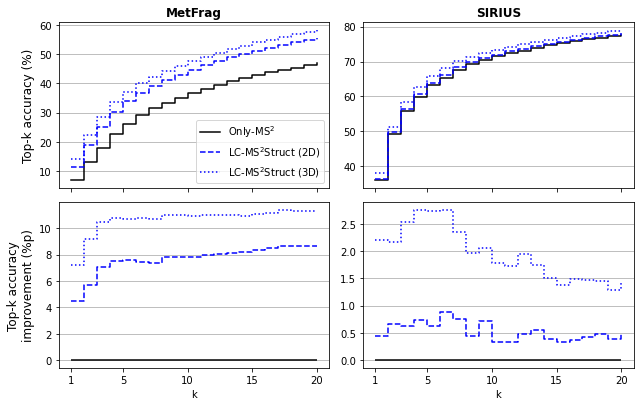

In [12]:
# __tmp__03__a = plot__03__a(
#     res__baseline=[
#         res__ssvm__cfmid4__2D[(res__ssvm__cfmid4__2D["scoring_method"] == "Only MS") & (res__ssvm__cfmid4__2D["n_models"] == 8)].assign(scoring_method="Only-MS$^2$", ms2scorer="CFM-ID"),
#         res__ssvm__metfrag__2D[(res__ssvm__metfrag__2D["scoring_method"] == "Only MS") & (res__ssvm__metfrag__2D["n_models"] == 8)].assign(scoring_method="Only-MS$^2$", ms2scorer="MetFrag"),
#         res__ssvm__sirius__2D[(res__ssvm__sirius__2D["scoring_method"] == "Only MS") & (res__ssvm__sirius__2D["n_models"] == 8)].assign(scoring_method="Only-MS$^2$", ms2scorer="SIRIUS")
#     ], 
#     res__ssvm__2D=[
#         res__ssvm__cfmid4__2D[(res__ssvm__cfmid4__2D["scoring_method"] == "MS + RT") & (res__ssvm__cfmid4__2D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (2D)", ms2scorer="CFM-ID"),
#         res__ssvm__metfrag__2D[(res__ssvm__metfrag__2D["scoring_method"] == "MS + RT") & (res__ssvm__metfrag__2D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (2D)", ms2scorer="MetFrag"),
#         res__ssvm__sirius__2D[(res__ssvm__sirius__2D["scoring_method"] == "MS + RT") & (res__ssvm__sirius__2D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (2D)", ms2scorer="SIRIUS")
#     ],
#     res__ssvm__3D=[
#         res__ssvm__cfmid4__3D[(res__ssvm__cfmid4__3D["scoring_method"] == "MS + RT") & (res__ssvm__cfmid4__3D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (3D)", ms2scorer="CFM-ID"),
#         res__ssvm__metfrag__3D[(res__ssvm__metfrag__3D["scoring_method"] == "MS + RT") & (res__ssvm__metfrag__3D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (3D)", ms2scorer="MetFrag"),
#         res__ssvm__sirius__3D[(res__ssvm__sirius__3D["scoring_method"] == "MS + RT") & (res__ssvm__sirius__3D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (3D)", ms2scorer="SIRIUS")
#     ],
#     max_k=20,
#     weighted_average=False,
#     raise_on_missing_results=True,
#     aspect="landscape",
#     verbose=True
# )

__tmp__03__a = plot__03__a(
    res__baseline=[
        res__ssvm__metfrag__2D[(res__ssvm__metfrag__2D["scoring_method"] == "Only MS") & (res__ssvm__metfrag__2D["n_models"] == 8)].assign(scoring_method="Only-MS$^2$", ms2scorer="MetFrag"),
        res__ssvm__sirius__2D[(res__ssvm__sirius__2D["scoring_method"] == "Only MS") & (res__ssvm__sirius__2D["n_models"] == 8)].assign(scoring_method="Only-MS$^2$", ms2scorer="SIRIUS")
    ], 
    res__ssvm__2D=[
        res__ssvm__metfrag__2D[(res__ssvm__metfrag__2D["scoring_method"] == "MS + RT") & (res__ssvm__metfrag__2D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (2D)", ms2scorer="MetFrag"),
        res__ssvm__sirius__2D[(res__ssvm__sirius__2D["scoring_method"] == "MS + RT") & (res__ssvm__sirius__2D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (2D)", ms2scorer="SIRIUS")
    ],
    res__ssvm__3D=[
        res__ssvm__metfrag__3D[(res__ssvm__metfrag__3D["scoring_method"] == "MS + RT") & (res__ssvm__metfrag__3D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (3D)", ms2scorer="MetFrag"),
        res__ssvm__sirius__3D[(res__ssvm__sirius__3D["scoring_method"] == "MS + RT") & (res__ssvm__sirius__3D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (3D)", ms2scorer="SIRIUS")
    ],
    max_k=20,
    weighted_average=False,
    raise_on_missing_results=True,
    aspect="landscape",
    verbose=True
)


for ext in ["pdf", "svg"]:
    plt.savefig(os.path.join(".", os.extsep.join(["plot_04__a", ext])))

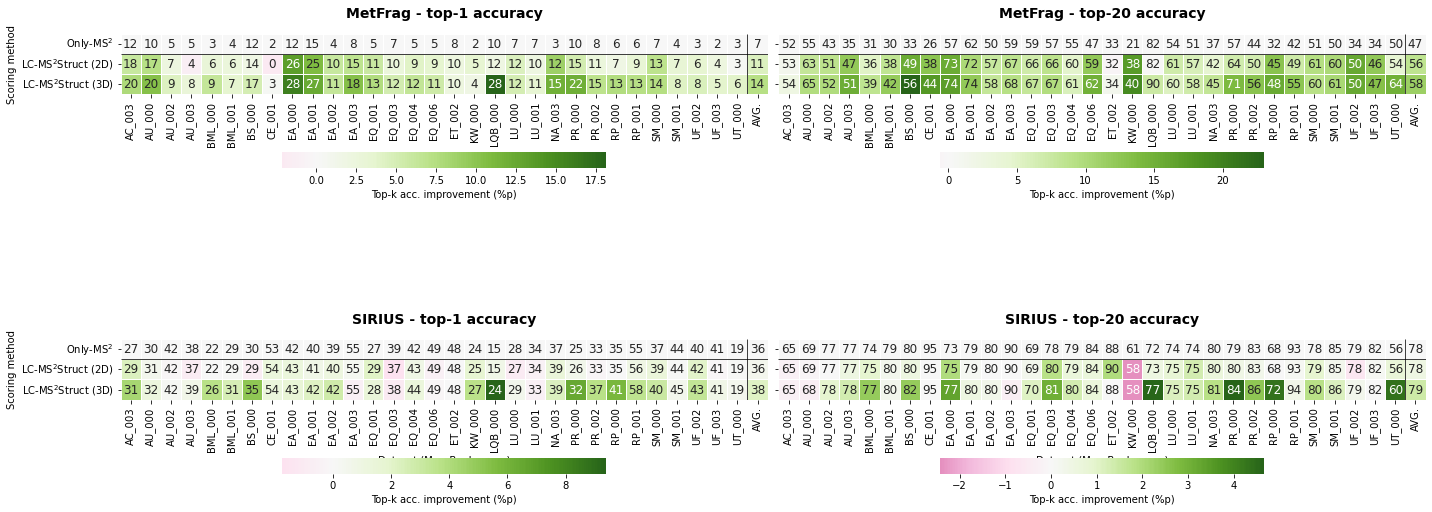

In [13]:
# __tmp__03__b = plot__03__b(
#     res__baseline=[
#         res__ssvm__cfmid4__2D[(res__ssvm__cfmid4__2D["scoring_method"] == "Only MS") & (res__ssvm__cfmid4__2D["n_models"] == 8)].assign(scoring_method="Only-MS$^2$", ms2scorer="CFM-ID"),
#         res__ssvm__metfrag__2D[(res__ssvm__metfrag__2D["scoring_method"] == "Only MS") & (res__ssvm__metfrag__2D["n_models"] == 8)].assign(scoring_method="Only-MS$^2$", ms2scorer="MetFrag"),
#         res__ssvm__sirius__2D[(res__ssvm__sirius__2D["scoring_method"] == "Only MS") & (res__ssvm__sirius__2D["n_models"] == 8)].assign(scoring_method="Only-MS$^2$", ms2scorer="SIRIUS")
#     ], 
#     res__ssvm__2D=[
#         res__ssvm__cfmid4__2D[(res__ssvm__cfmid4__2D["scoring_method"] == "MS + RT") & (res__ssvm__cfmid4__2D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (2D)", ms2scorer="CFM-ID"),
#         res__ssvm__metfrag__2D[(res__ssvm__metfrag__2D["scoring_method"] == "MS + RT") & (res__ssvm__metfrag__2D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (2D)", ms2scorer="MetFrag"),
#         res__ssvm__sirius__2D[(res__ssvm__sirius__2D["scoring_method"] == "MS + RT") & (res__ssvm__sirius__2D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (2D)", ms2scorer="SIRIUS")
#     ],
#     res__ssvm__3D=[
#         res__ssvm__cfmid4__3D[(res__ssvm__cfmid4__3D["scoring_method"] == "MS + RT") & (res__ssvm__cfmid4__3D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (3D)", ms2scorer="CFM-ID"),
#         res__ssvm__metfrag__3D[(res__ssvm__metfrag__3D["scoring_method"] == "MS + RT") & (res__ssvm__metfrag__3D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (3D)", ms2scorer="MetFrag"),
#         res__ssvm__sirius__3D[(res__ssvm__sirius__3D["scoring_method"] == "MS + RT") & (res__ssvm__sirius__3D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (3D)", ms2scorer="SIRIUS")
#     ],
#     ks=[1, 20],
#     weighted_average=False,
#     raise_on_missing_results=True,
#     ctype="improvement",
#     label_format=".0f"
# )

__tmp__03__b = plot__03__b(
    res__baseline=[
        res__ssvm__metfrag__2D[(res__ssvm__metfrag__2D["scoring_method"] == "Only MS") & (res__ssvm__metfrag__2D["n_models"] == 8)].assign(scoring_method="Only-MS$^2$", ms2scorer="MetFrag"),
        res__ssvm__sirius__2D[(res__ssvm__sirius__2D["scoring_method"] == "Only MS") & (res__ssvm__sirius__2D["n_models"] == 8)].assign(scoring_method="Only-MS$^2$", ms2scorer="SIRIUS")
    ], 
    res__ssvm__2D=[
        res__ssvm__metfrag__2D[(res__ssvm__metfrag__2D["scoring_method"] == "MS + RT") & (res__ssvm__metfrag__2D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (2D)", ms2scorer="MetFrag"),
        res__ssvm__sirius__2D[(res__ssvm__sirius__2D["scoring_method"] == "MS + RT") & (res__ssvm__sirius__2D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (2D)", ms2scorer="SIRIUS")
    ],
    res__ssvm__3D=[
        res__ssvm__metfrag__3D[(res__ssvm__metfrag__3D["scoring_method"] == "MS + RT") & (res__ssvm__metfrag__3D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (3D)", ms2scorer="MetFrag"),
        res__ssvm__sirius__3D[(res__ssvm__sirius__3D["scoring_method"] == "MS + RT") & (res__ssvm__sirius__3D["n_models"] == 8)].assign(scoring_method="LC-MS$^2$Struct (3D)", ms2scorer="SIRIUS")
    ],
    ks=[1, 20],
    weighted_average=False,
    raise_on_missing_results=True,
    ctype="improvement",
    label_format=".0f"
)

for ext in ["pdf", "svg"]:
    plt.savefig(os.path.join(".", os.extsep.join(["plot_04__b", ext])))

MassBank subsets with only one (1) samples (i.e., not subset specific training data):
- CE_001
- ET_002
- KW_000
- RP_000